# Antimicrobial Peptides Sequence Data Analysis


In [1]:
# import packages
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import seaborn as sns
import matplotlib.pyplot as plt
from modlamp.descriptors import GlobalDescriptor
from modlamp.sequences import Random
from modlamp.analysis import GlobalAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## Collect Data
### I downloaded datasets from antimicrobial peptide databases, both them are FASTA format
### APD3: https://aps.unmc.edu/AP/
### DBAASP: https://dbaasp.org/home

In [2]:
# Data
apd3_fasta_path = 'APD3.fasta'
dbaasp_fasta_path = 'DBAASP.fasta'

## Process Data

In [3]:
def read_fasta_into_df(fasta_file_path):
    # Use SeqIO to parse the FASTA file
    sequences = SeqIO.parse(fasta_file_path, 'fasta')

    # Create lists to store data
    ids = []
    sequences_data = []

    # Iterate over the sequences and extract information
    for seq_record in sequences:
        ids.append(seq_record.id)
        sequences_data.append(str(seq_record.seq))

    # Create a DataFrame
    df = pd.DataFrame({
        'ID': ids,
        'Sequence': sequences_data,
    })

    return df

In [4]:
def merge_and_check_duplicates(fasta_file_path1, fasta_file_path2):
    # Read sequences from the FASTA file into a DataFrame
    df1 = read_fasta_into_df(fasta_file_path1)
    print(f'There are {len(df1)} sequences in {fasta_file_path1}')

    df2 = read_fasta_into_df(fasta_file_path2)
    print(f'There are {len(df2)} sequences in {fasta_file_path2}')

    # Merge the two DataFrames
    merged_df = pd.concat([df1, df2], ignore_index=True)

    # Identify duplicate sequences
    duplicates_df = merged_df[merged_df.duplicated(subset='Sequence', keep=False)]
    print(f'There are {len(duplicates_df)} duplicated sequences')

    # Keep only unique rows
    unique_df = merged_df.drop_duplicates(subset='Sequence')
    print(f'There are {len(unique_df)} unique sequences in total')

    return unique_df, duplicates_df

### 1. Merge two datasets 

In [5]:
unique_df, duplicates_df = merge_and_check_duplicates(apd3_fasta_path, dbaasp_fasta_path)

There are 3167 sequences in APD3.fasta
There are 20794 sequences in DBAASP.fasta
There are 8016 duplicated sequences
There are 19150 unique sequences in total


In [6]:
def filter_common_amino_acids(df):
    # List of the 20 common amino acids
    common_amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                         'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

    # Filter the DataFrame to include only rows with sequences of the 20 usual amino acids
    filtered_df = df[df['Sequence'].apply(lambda seq: all(aa in common_amino_acids for aa in seq))].reset_index(drop=True)

    # Print the amount of data before and after filtering
    print(f"Original DataFrame size: {len(df)} sequences")
    print(f"Filtered DataFrame size: {len(filtered_df)} sequences")
    print(f"{len(df) - len(filtered_df)} sequences with unusual amino acids")

    return filtered_df

### 2. Filter amino acids

In [7]:
filtered_df = filter_common_amino_acids(unique_df)

Original DataFrame size: 19150 sequences
Filtered DataFrame size: 15413 sequences
3737 sequences with unusual amino acids


In [8]:
def rename_ids_by_length(df, basename='AMP'):
    # Get the length of the DataFrame
    df_length = len(df)

    # Generate new 'ID' values based on the length of the DataFrame
    new_ids = [f'{basename}_{i}' for i in range(1, df_length + 1)]

    
    # Rename the 'ID' column using the copy
    df_copy = df.copy()
    df_copy['ID'] = new_ids
    
    return df_copy

### 3. Rename data ID

In [9]:
renamed_df = rename_ids_by_length(filtered_df)

In [10]:
renamed_df

,ID,Sequence
0,AMP_1,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV
1,AMP_2,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY
2,AMP_3,DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...
3,AMP_4,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC
4,AMP_5,VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK
...,...,...
15408,AMP_15409,GWAKRLATRLAKAIL
15409,AMP_15410,KKIFKRIVKIIKRLL
15410,AMP_15411,KILGKLLKWASKIW
15411,AMP_15412,LSKWLKKLGKLLAG


In [11]:
def save_df_to_fasta(df, output_fasta_path):
    
    # Create a list to store SeqRecord objects
    records = []

    # Iterate over DataFrame rows and create SeqRecord objects
    for _, row in df.iterrows():
        record = SeqRecord(Seq(row['Sequence']), id=row['ID'],  description='')
        records.append(record)

    # Write SeqRecord objects to a FASTA file
    SeqIO.write(records, output_fasta_path+f'_{len(df)}.fasta', 'fasta')


### Totally get 15413 AMPs

### 4. Save cleaned data

In [12]:
save_df_to_fasta(renamed_df, 'cleaned_data')

## Visualize Data

In [13]:
renamed_df['Length'] = renamed_df['Sequence'].apply(len)

In [14]:
renamed_df

,ID,Sequence,Length
0,AMP_1,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV,33
1,AMP_2,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,34
2,AMP_3,DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...,54
3,AMP_4,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC,49
4,AMP_5,VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK,34
...,...,...,...
15408,AMP_15409,GWAKRLATRLAKAIL,15
15409,AMP_15410,KKIFKRIVKIIKRLL,15
15410,AMP_15411,KILGKLLKWASKIW,14
15411,AMP_15412,LSKWLKKLGKLLAG,14


### Histogram

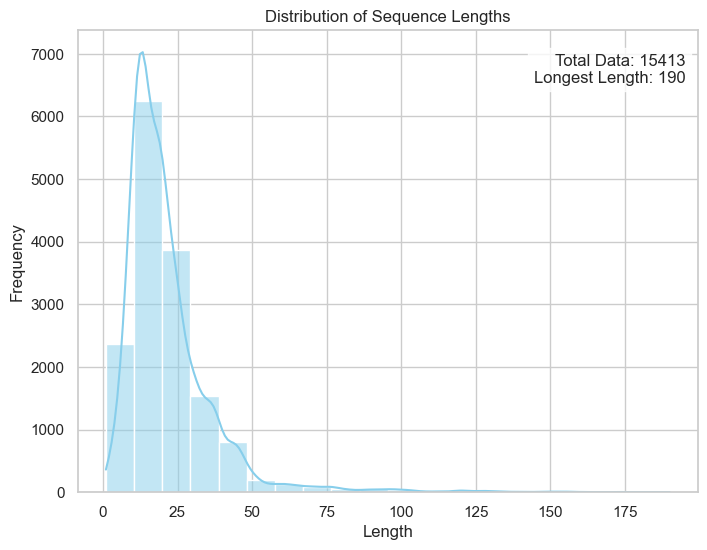

In [15]:
# Set the seaborn style
sns.set(style="whitegrid")

# Create a histogram of sequence lengths
plt.figure(figsize=(8, 6))
sns.histplot(data=renamed_df, x='Length', bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
total_data = len(renamed_df)
longest_length = renamed_df['Length'].max()
plt.text(0.98, 0.95, f'Total Data: {total_data}\nLongest Length: {longest_length}', 
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

### 2. Boxplot

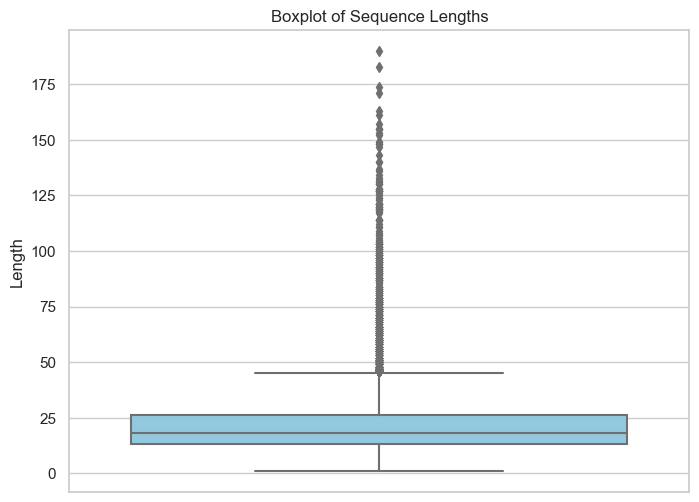

In [16]:
# Create a boxplot of sequence lengths
plt.figure(figsize=(8, 6))
sns.boxplot(data=renamed_df, y='Length', color='skyblue')
plt.title('Boxplot of Sequence Lengths')
plt.ylabel('Length')
plt.show()

### 3. Violin plot

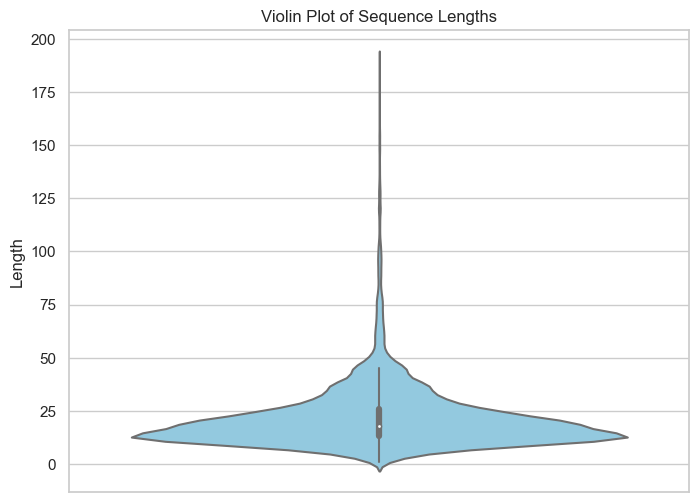

In [17]:
# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=renamed_df, y='Length', color='skyblue')
plt.title('Violin Plot of Sequence Lengths')
plt.ylabel('Length')
plt.show()

### Most AMPs length are between 5 to 50 amino acids

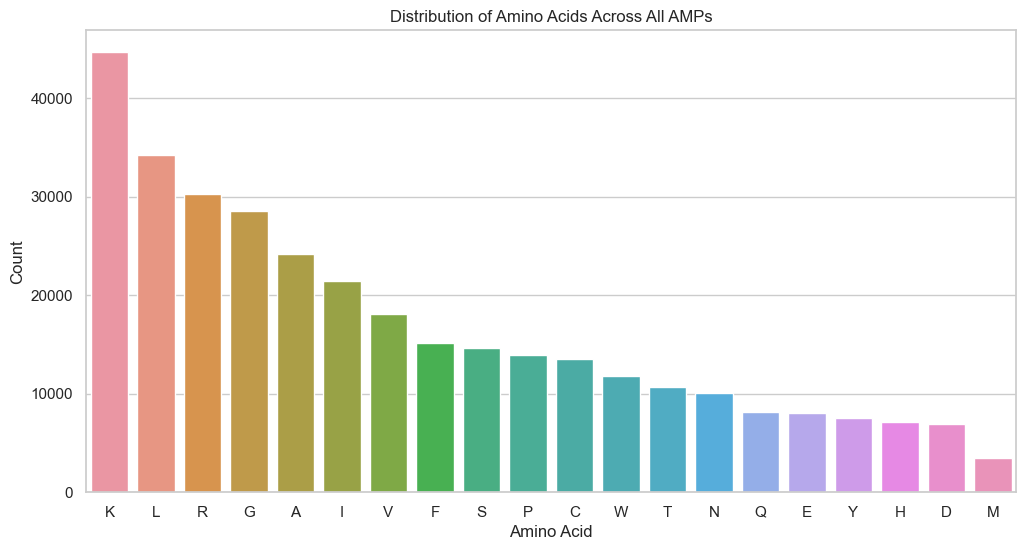

In [18]:
# Concatenate all sequences into a single string
all_sequences = ''.join(renamed_df['Sequence'])

# Count the occurrences of each amino acid
amino_acid_counts = pd.Series(list(all_sequences)).value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=amino_acid_counts.index, y=amino_acid_counts.values)
plt.title('Distribution of Amino Acids Across All AMPs')
plt.xlabel('Amino Acid')
plt.ylabel('Count')
plt.show()

In [19]:
# Calculate the percentage of each amino acid
amino_acid_percentage = amino_acid_counts / len(all_sequences) * 100

# Create a table
percentage_table = pd.DataFrame({
    'Amino Acid': amino_acid_percentage.index,
    'Percentage': amino_acid_percentage.values
})

percentage_table

,Amino Acid,Percentage
0,K,13.436323
1,L,10.284403
2,R,9.110289
3,G,8.578705
4,A,7.269589
5,I,6.439741
6,V,5.435505
7,F,4.552739
8,S,4.417738
9,P,4.195543


### The Most amount amino acids of AMPs is K (Lysine)

## Analyze Data

In [20]:
def calculate_properties(df):
    # Extract peptide sequences from the DataFrame
    sequences = df['Sequence'].tolist()

    # Initialize a PeptideDescriptor object with the sequences
    descriptor = GlobalDescriptor(seqs=sequences)

    # Calculate various descriptors for each sequence in the DataFrame
    descriptor.calculate_all()
    descriptor_df = pd.DataFrame(descriptor.descriptor, columns=['Length', 'MW', 'Charge', 'ChargeDensity', 'pI', 'InstabilityInd', 'Aromaticity', 'AliphaticInd', 'BomanInd', 'HydrophRatio'])
     
    # Concatenate the original DataFrame and the new descriptor DataFrame
    df = pd.concat([df, descriptor_df], axis=1)
    

    return df

### calculate AMP's properties

In [21]:
renamed_df= calculate_properties(renamed_df.iloc[:,0:2])

In [22]:
renamed_df

,ID,Sequence,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,AMP_1,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV,33.0,3180.71,3.988,0.001254,10.683594,7.272727,0.030303,95.151515,0.231818,0.515152
1,AMP_2,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,34.0,3877.48,4.985,0.001286,11.458496,84.155882,0.176471,40.000000,1.198235,0.205882
2,AMP_3,DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...,54.0,5947.71,2.878,0.000484,8.126221,57.074074,0.111111,27.037037,1.954444,0.314815
3,AMP_4,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC,49.0,5613.26,1.881,0.000335,7.916870,16.722449,0.122449,22.040816,2.433673,0.306122
4,AMP_5,VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK,34.0,3749.38,1.031,0.000275,9.650391,13.861765,0.088235,117.647059,0.551765,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
15408,AMP_15409,GWAKRLATRLAKAIL,15.0,1667.06,4.989,0.002993,13.714844,42.113333,0.066667,130.666667,0.888000,0.533333
15409,AMP_15410,KKIFKRIVKIIKRLL,15.0,1895.52,7.987,0.004214,13.726562,18.220000,0.066667,175.333333,1.403333,0.533333
15410,AMP_15411,KILGKLLKWASKIW,14.0,1683.14,4.987,0.002963,13.140625,-18.014286,0.142857,146.428571,-0.457857,0.428571
15411,AMP_15412,LSKWLKKLGKLLAG,14.0,1553.99,4.987,0.003209,13.140625,-6.157143,0.071429,146.428571,-0.358571,0.428571


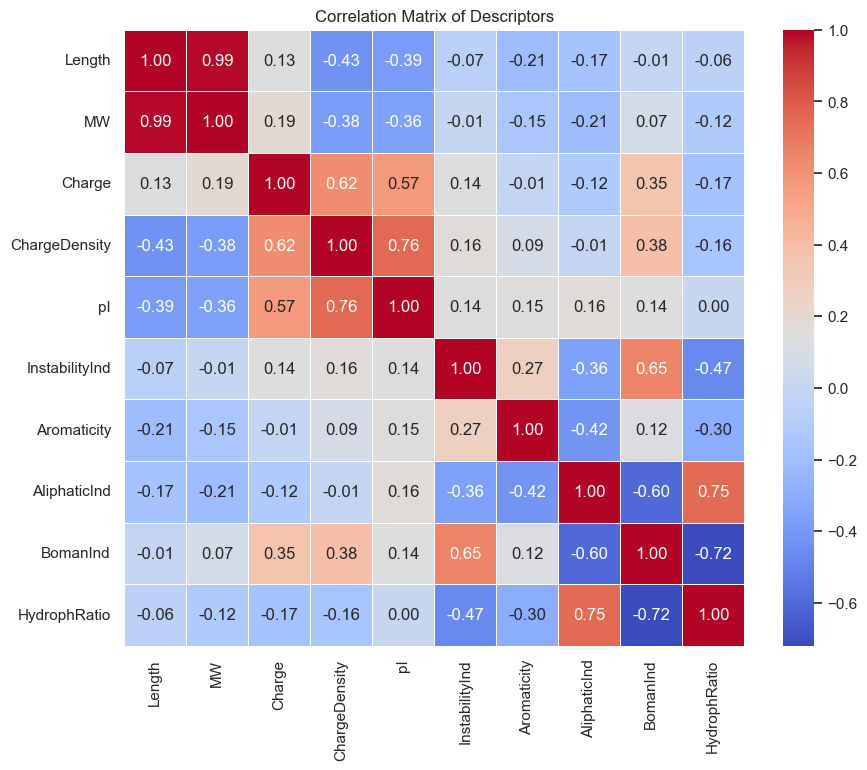

In [23]:
correlation_matrix = renamed_df.iloc[:, 2:].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Descriptors')
plt.show()

### Length and MV, HydrophRatio and Bomanlmd, HydrophRatio and Aliphaticlnd highly correlation

### Random generated sequences

In [24]:
b = Random(len(renamed_df), 5, 50)
b.generate_sequences(proba='rand')
ids = [f'Random_{i}' for i in range(1, len(renamed_df) + 1)]
random_df = pd.DataFrame({
    'ID': ids,
    'Sequence': b.sequences
})
random_df = calculate_properties(random_df)

In [25]:
random_df

,ID,Sequence,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,Random_1,NIKAQKFGYCPGDVDND,17.0,1883.06,-0.167,-0.000089,6.156250,27.758824,0.117647,45.882353,2.312353,0.294118
1,Random_2,PGKGCIALIESCFAYMHLSCWHETCCFEMV,30.0,3409.07,-1.697,-0.000498,6.038574,96.333333,0.133333,68.333333,-0.126667,0.533333
2,Random_3,ILFEHTKMGEWETQEVYVYRIDHYLLVEIEQHFLKQHWKNYEN,43.0,5537.20,-2.849,-0.000515,5.678223,36.441860,0.186047,83.720930,1.900698,0.302326
3,Random_4,VMVLQCPFNWHVCNFYHHCFPSSMCVNLVSADNFKM,36.0,4249.01,0.497,0.000117,7.686523,51.691944,0.166667,64.722222,0.345000,0.527778
4,Random_5,KQKREYQGEGH,11.0,1358.47,2.030,0.001494,10.231934,53.363636,0.090909,0.000000,4.876364,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
15408,Random_15409,CCVTRVWNIYYCHFCVGIKNIIKQDFHTNWDKHEQETN,38.0,4686.31,0.495,0.000106,7.684082,34.652632,0.157895,63.947368,1.941053,0.342105
15409,Random_15410,HLSAMYYQ,8.0,1011.16,1.027,0.001016,9.522949,53.775000,0.250000,61.250000,0.600000,0.375000
15410,Random_15411,ENPGYYRFRGPNKRPTMHVCDETGVPIFQYQGQRECAIMNQTQNMSNN,48.0,5621.25,1.719,0.000306,8.795898,52.225000,0.104167,30.416667,2.896875,0.250000
15411,Random_15412,CAHHDGDNMTHCVEPCFPLASFEYQTWWPSGKG,33.0,3751.14,-2.348,-0.000626,5.771484,9.490909,0.151515,26.666667,1.292121,0.303030


### Compare AMPs and Random sequences

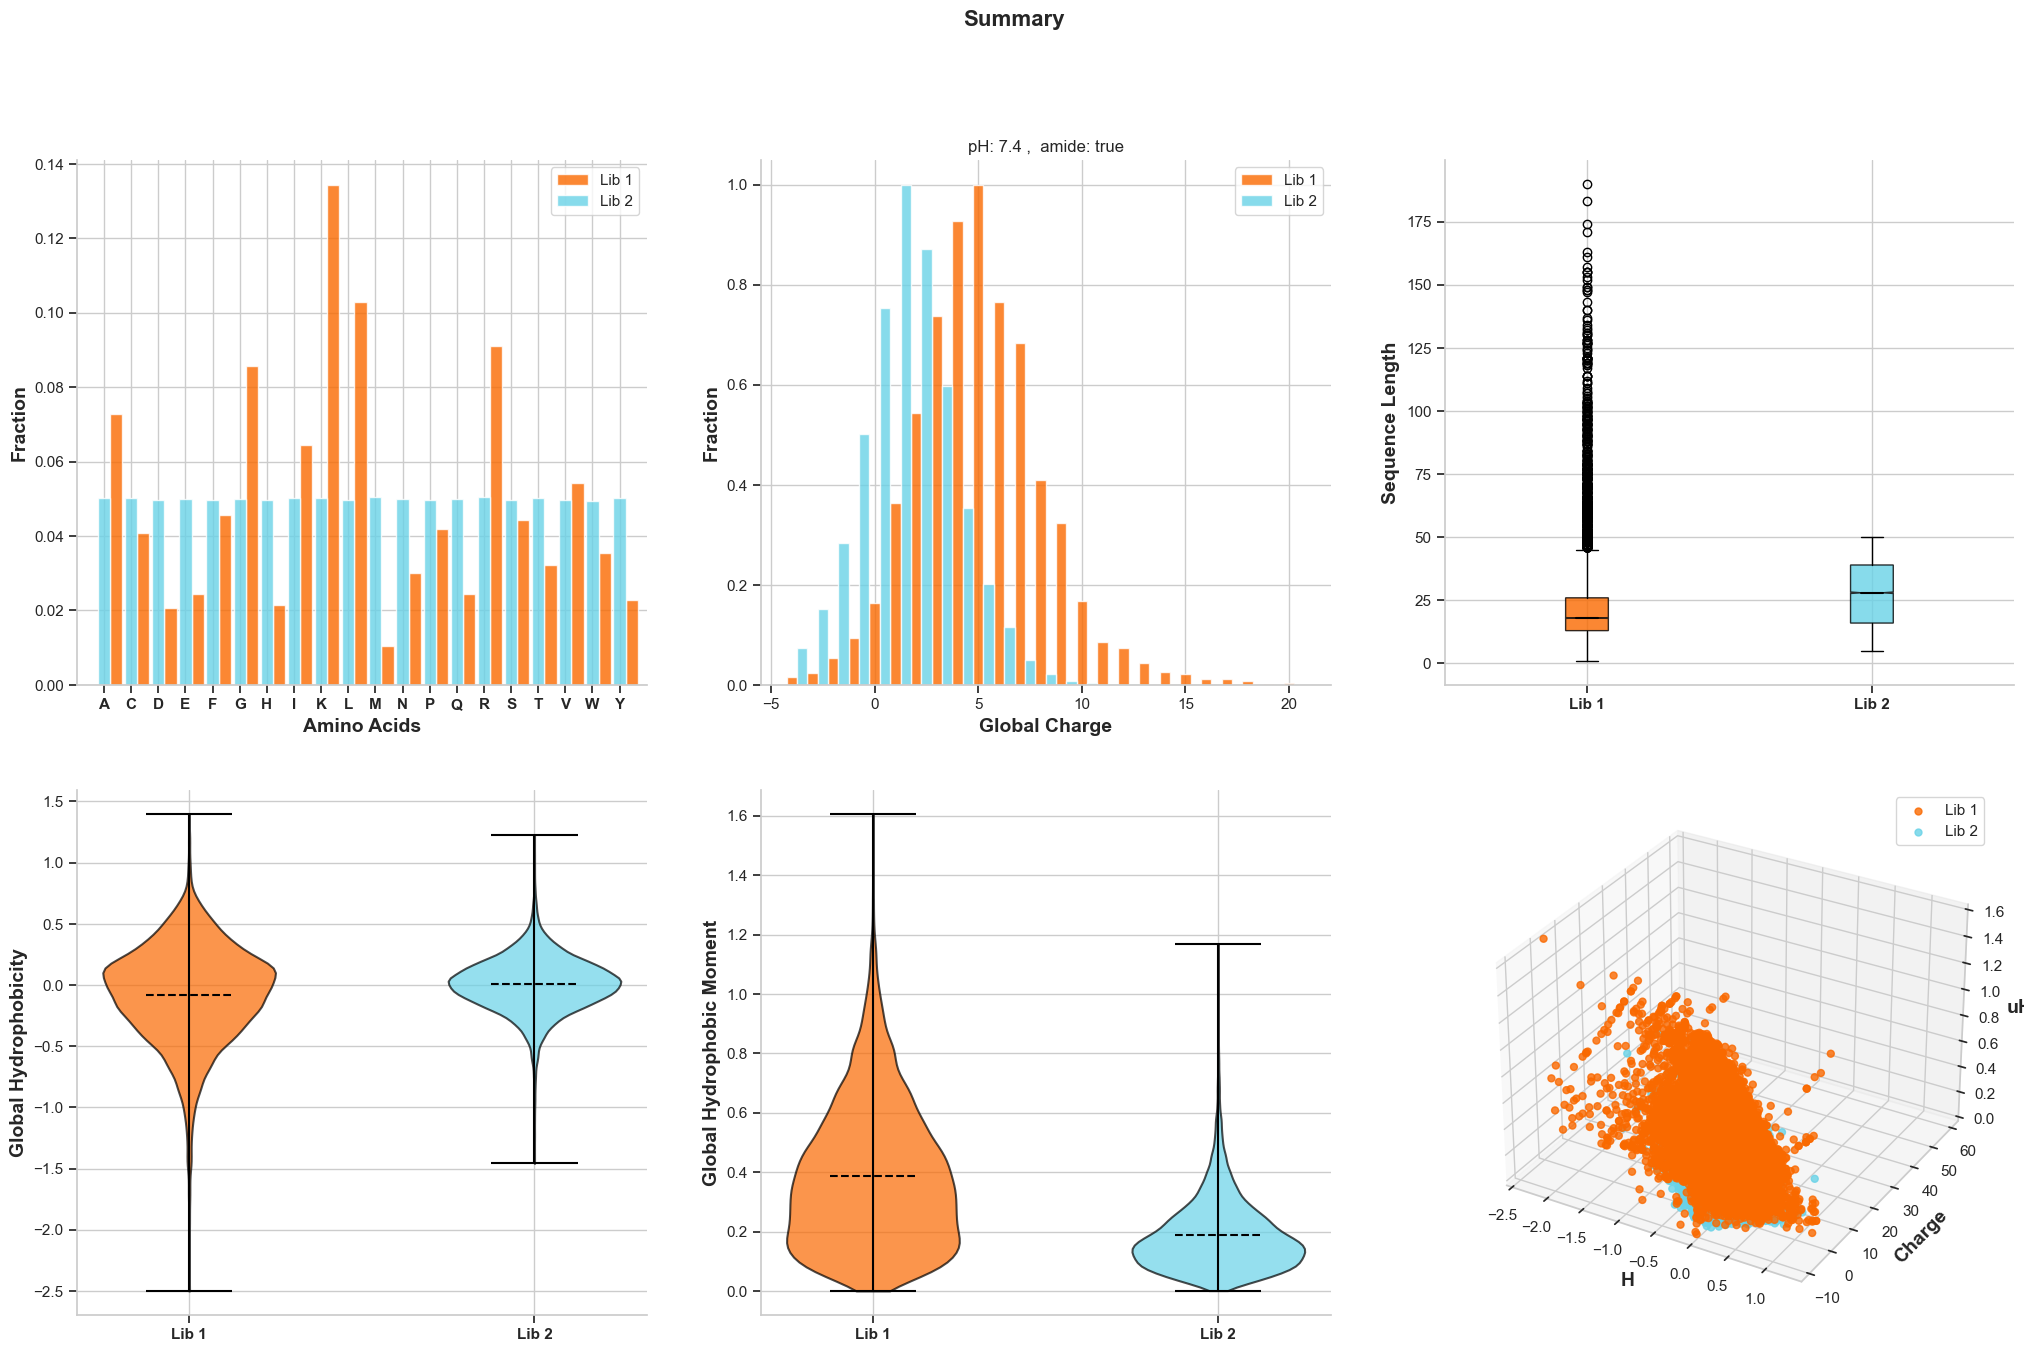

In [26]:
g = GlobalAnalysis([renamed_df['Sequence'].tolist(),random_df['Sequence'].tolist()]) 
g.plot_summary()

### AMPs have higher global charge and global hydrophobic moment

### Machine learning to test if it is possible to predict AMPs by descriptor values

In [27]:
all_df = pd.concat([renamed_df, random_df], ignore_index=True)
labels = [1]*len(renamed_df)+[0]*len(renamed_df)
all_df['Label']=labels

In [28]:
all_df

,ID,Sequence,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio,Label
0,AMP_1,GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV,33.0,3180.71,3.988,0.001254,10.683594,7.272727,0.030303,95.151515,0.231818,0.515152,1
1,AMP_2,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,34.0,3877.48,4.985,0.001286,11.458496,84.155882,0.176471,40.000000,1.198235,0.205882,1
2,AMP_3,DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...,54.0,5947.71,2.878,0.000484,8.126221,57.074074,0.111111,27.037037,1.954444,0.314815,1
3,AMP_4,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC,49.0,5613.26,1.881,0.000335,7.916870,16.722449,0.122449,22.040816,2.433673,0.306122,1
4,AMP_5,VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK,34.0,3749.38,1.031,0.000275,9.650391,13.861765,0.088235,117.647059,0.551765,0.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30821,Random_15409,CCVTRVWNIYYCHFCVGIKNIIKQDFHTNWDKHEQETN,38.0,4686.31,0.495,0.000106,7.684082,34.652632,0.157895,63.947368,1.941053,0.342105,0
30822,Random_15410,HLSAMYYQ,8.0,1011.16,1.027,0.001016,9.522949,53.775000,0.250000,61.250000,0.600000,0.375000,0
30823,Random_15411,ENPGYYRFRGPNKRPTMHVCDETGVPIFQYQGQRECAIMNQTQNMSNN,48.0,5621.25,1.719,0.000306,8.795898,52.225000,0.104167,30.416667,2.896875,0.250000,0
30824,Random_15412,CAHHDGDNMTHCVEPCFPLASFEYQTWWPSGKG,33.0,3751.14,-2.348,-0.000626,5.771484,9.490909,0.151515,26.666667,1.292121,0.303030,0


In [29]:
# Extract features (descriptors) and labels
X = all_df.iloc[:,3:-1]
y = all_df.iloc[:,-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=42,max_iter=10000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.83
Precision: 0.83
Recall: 0.81
Confusion Matrix:
[[2583  500]
 [ 573 2510]]


### Based on the ML results, We can use descriptors to identify unknown peptides are AMPs or not